# 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import cv2
from PIL import Image
from skimage.io import imread

import os
import random
from tqdm import tqdm

In [2]:
import torch
from torch import nn, optim
from torch.nn import functional
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [3]:
import warnings
warnings.filterwarnings("ignore")

# 2. Device Management

In [4]:
if torch.cuda.is_available():
    default_device = torch.device("cuda")
else:
    default_device = torch.device("cpu")

default_device

device(type='cuda')

In [5]:
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# 3. Dataset Preparation

## 3-1. Extract Class Names

In [6]:
data_dir = '/kaggle/input/rice-image-dataset/Rice_Image_Dataset'

In [7]:
class_names = [name for name in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, name))]

print('Class Names:', class_names)

Class Names: ['Karacadag', 'Basmati', 'Jasmine', 'Arborio', 'Ipsala']


## 3-2. Extract Image Paths

In [8]:
class_image_paths = {
    'Arborio': [],
    'Basmati': [],
    'Ipsala': [],
    'Jasmine': [],
    'Karacadag': []
}

for class_name in class_names:

    class_dir = f"{data_dir}/{class_name}"
    
    for file in os.listdir(class_dir):
        
        if file.endswith(".png") or file.endswith(".jpg"): 
            class_image_paths[class_name].append(
                os.path.join(class_dir, file)
            )

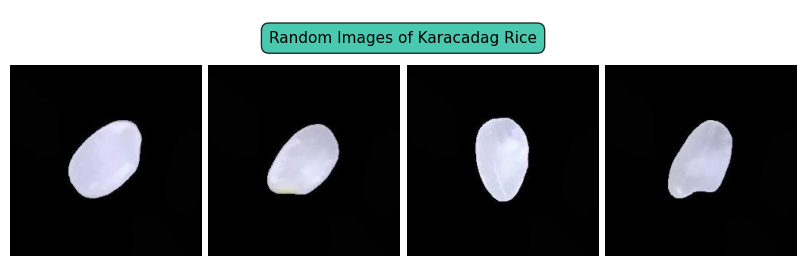

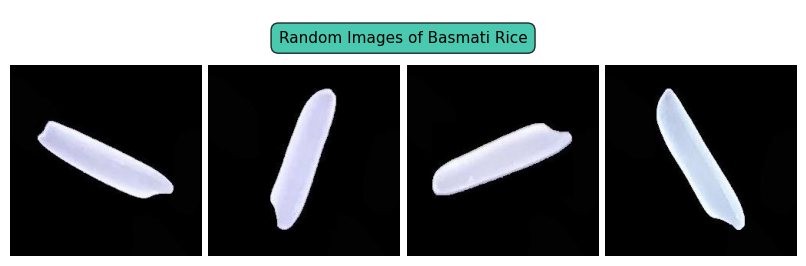

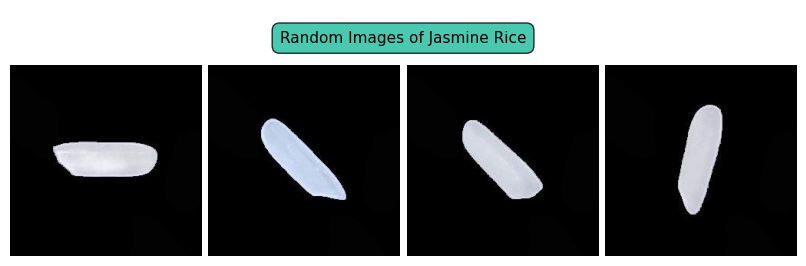

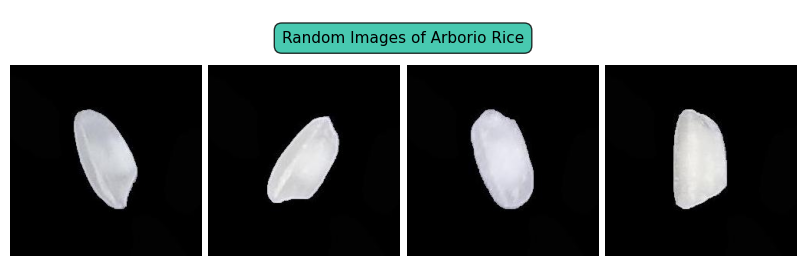

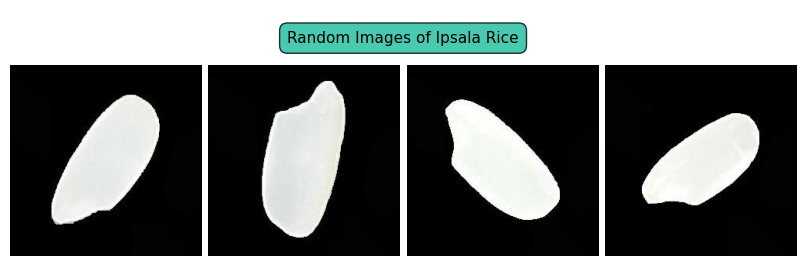

In [9]:
for class_name in class_names:
    fig = plt.figure(figsize=(8, 3))
    gs = gridspec.GridSpec(2, 4, height_ratios=[0.1, 0.95])

    title_ax = fig.add_subplot(gs[0, :])
    title_ax.text(0.5, 0, f"Random Images of {class_name} Rice",
                  fontsize=11, ha='center', va='center',
                  bbox=dict(facecolor='#1ABC9C', edgecolor='black', boxstyle='round,pad=0.5', alpha=0.8))
    title_ax.axis('off')

    for j in range(4):
        ax = fig.add_subplot(gs[1, j])
        random_img = random.choice(class_image_paths[class_name])
        img = imread(random_img)
        ax.imshow(img)
        ax.axis('off')

    plt.tight_layout(pad=0.5)
    plt.show()

## 3-3. Create DataFrames for Data Generators

In [10]:
print(f"Number of Samples in Classes:")

for class_name in class_names:
    print(f"{class_name:9} =" ,len(class_image_paths[class_name]))

Number of Samples in Classes:
Karacadag = 15000
Basmati   = 15000
Jasmine   = 15000
Arborio   = 15000
Ipsala    = 15000


In [11]:
# 75% of the Data
train_df = pd.concat([
    pd.DataFrame({'image': class_image_paths['Arborio'][:11250]  , 'label': 'Arborio'}), 
    pd.DataFrame({'image': class_image_paths['Basmati'][:11250]  , 'label': 'Basmati'}), 
    pd.DataFrame({'image': class_image_paths['Ipsala'][:11250]   , 'label': 'Ipsala'}), 
    pd.DataFrame({'image': class_image_paths['Jasmine'][:11250]  , 'label': 'Jasmine'}), 
    pd.DataFrame({'image': class_image_paths['Karacadag'][:11250], 'label': 'Karacadag'})
])

# 20% of the Data
val_df = pd.concat([
    pd.DataFrame({'image': class_image_paths['Arborio'][11250:14250]  , 'label': 'Arborio'}), 
    pd.DataFrame({'image': class_image_paths['Basmati'][11250:14250]  , 'label': 'Basmati'}), 
    pd.DataFrame({'image': class_image_paths['Ipsala'][11250:14250]   , 'label': 'Ipsala'}), 
    pd.DataFrame({'image': class_image_paths['Jasmine'][11250:14250]  , 'label': 'Jasmine'}), 
    pd.DataFrame({'image': class_image_paths['Karacadag'][11250:14250], 'label': 'Karacadag'})
])

# 5% of the Data
test_df = pd.concat([
    pd.DataFrame({'image': class_image_paths['Arborio'][14250:15000]  , 'label': 'Arborio'}), 
    pd.DataFrame({'image': class_image_paths['Basmati'][14250:15000]  , 'label': 'Basmati'}), 
    pd.DataFrame({'image': class_image_paths['Ipsala'][14250:15000]   , 'label': 'Ipsala'}), 
    pd.DataFrame({'image': class_image_paths['Jasmine'][14250:15000]  , 'label': 'Jasmine'}), 
    pd.DataFrame({'image': class_image_paths['Karacadag'][14250:15000], 'label': 'Karacadag'})
])

In [12]:
print('Number of Train Data:', len(train_df))
print('Number of Validation Data:', len(val_df))
print('Number of Test Data:', len(test_df))

Number of Train data: 56250
Number of Validation data: 15000
Number of Test data: 3750


## 3-4. Create Data Loaders

In [13]:
class ImageDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = None
        self.classes = sorted(self.dataframe['label'].unique())
        self.class_to_idx = {c: i for i, c in enumerate(self.classes)}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image']
        image = Image.open(img_path).convert('RGB')
        label_name = self.dataframe.iloc[idx]['label']
        label = self.class_to_idx[label_name]
        if self.transform:
            image = self.transform(image)
        return image, label

    def set_transform(self, img_height, img_width):
        self.transform = transforms.Compose([
            transforms.Resize((img_height, img_width)),
            transforms.ToTensor()
        ])

In [14]:
print('Random Image Shapes:')

for i in range(1,6):
    random_img_path = random.choice(random.choice(list(class_image_paths.values())))
    image = cv2.imread(random_img_path)
    print(f'{i}. {image.shape[:2]}')

Random Image Shapes:
1. (250, 250)
2. (250, 250)
3. (250, 250)
4. (250, 250)
5. (250, 250)


In [15]:
img_height, img_width = (250, 250)
batch_size = 128

In [16]:
train_dataset = ImageDataset(train_df)
val_dataset   = ImageDataset(val_df)
test_dataset  = ImageDataset(test_df)

In [17]:
train_dataset.set_transform(img_height, img_width)
val_dataset.set_transform(img_height, img_width)
test_dataset.set_transform(img_height, img_width)

In [18]:
class DeviceDataLoader:
    
    def __init__(self, dataloader, device):
        self.dataloader = dataloader
        self.device = device

    def __iter__(self):
        for batch in self.dataloader:
            yield to_device(batch, self.device)

    def __len__(self):
        return len(self.dataloader)

In [19]:
train_loader = DeviceDataLoader(
    DataLoader(
        train_dataset,
        batch_size = batch_size, 
        shuffle = True,
        pin_memory = True
    ), 
    default_device
)

val_loader = DeviceDataLoader(
    DataLoader(
        val_dataset, 
        batch_size = batch_size, 
        shuffle = True,
        pin_memory = True
    ), 
    default_device
)

test_loader = DeviceDataLoader(
    DataLoader(
        test_dataset, 
        batch_size = batch_size, 
        shuffle = True,
        pin_memory = True
    ), 
    default_device
)

# 4. Modeling

## 4-1. Build Model

In [20]:
def calc_accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    accuracy = torch.tensor(torch.sum(preds == labels).item() / len(preds))
    return accuracy

def calc_loss(outputs, labels, detach_loss):
    loss = functional.cross_entropy(outputs, labels)
    if detach_loss:
        loss = loss.detach()
    return loss

def process_batch(model, batch, detach_loss=False):
    images, labels = batch
    outputs = model(images)
    acc = calc_accuracy(outputs, labels)
    loss = calc_loss(outputs, labels, detach_loss=detach_loss)
    return acc, loss

In [21]:
# The model is based on the AlexNet architecture.

class Model(nn.Module):
    
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(96),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256*6*6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),

            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),

            nn.Linear(4096, num_classes)
        )
        
    
    def forward(self, x):
        out = self.classifier(
            self.features(x)
        )
        return out
        

    def fit(self, epochs, opt_func, max_lr, train_loader, val_loader):
        
        torch.cuda.empty_cache()
        optimizer = opt_func(self.parameters(), max_lr)
        sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
        self.history = []
        
        for epoch in range(epochs):

            report = {}
            
            report['Epoch'] = f"{epoch+1}/{epochs}"
            print(f"Epoch: {report['Epoch']}")
            
    
            self.train()
            train_accs = []
            train_losses = []
            
            for batch in tqdm(train_loader, desc="Training Batches"):
                acc, loss = process_batch(self, batch, detach_loss=False)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                sched.step()

                train_accs.append(acc)
                train_losses.append(loss)
                
            report['train_acc'] = torch.stack(train_accs).mean().item()
            report['train_loss'] = torch.stack(train_losses).mean().item()
            print(f"Accuracy: {report['train_acc']:.4f} | Loss: {report['train_loss']:.4f}")
                
    
            self.eval()
            val_accs = []
            val_losses = []
    
            for batch in tqdm(val_loader, desc="Validation Batches"):
                acc, loss = process_batch(self, batch, detach_loss=True)

                val_accs.append(acc)
                val_losses.append(loss)

            report['val_acc'] = torch.stack(val_accs).mean().item()
            report['val_loss'] = torch.stack(val_losses).mean().item()
            print(f"Accuracy: {report['val_acc']:.4f} | Loss: {report['val_loss']:.4f}")
            print()
                
                    
            self.history.append(report)


    def evaluate(self, test_loader):
       
        self.eval()
        test_accs = []
        test_losses = []

        for batch in tqdm(test_loader, desc="Test Batches"):
            acc, loss = process_batch(self, batch, detach_loss=True)

            test_accs.append(acc)
            test_losses.append(loss)

        test_acc = torch.stack(test_accs).mean().item()
        test_loss = torch.stack(test_losses).mean().item()

        return test_acc, test_loss
            

    def set_device(self, device):
        self = to_device(self, device)

In [22]:
model = Model(len(class_names))

In [23]:
model.set_device(default_device)

## 4-2. Model Training

In [24]:
epochs = 2
optimizer = optim.Adam
lr_rate = 0.001

In [25]:
model.fit(epochs, optimizer, lr_rate, train_loader, val_loader)

Epoch: 1/2


Training Batches: 100%|██████████| 440/440 [05:03<00:00,  1.45it/s]


Accuracy: 0.9071 | Loss: 0.2640


Validation Batches: 100%|██████████| 118/118 [01:16<00:00,  1.55it/s]


Accuracy: 0.9662 | Loss: 0.1027

Epoch: 2/2


Training Batches: 100%|██████████| 440/440 [02:12<00:00,  3.33it/s]


Accuracy: 0.9812 | Loss: 0.0561


Validation Batches: 100%|██████████| 118/118 [00:34<00:00,  3.40it/s]

Accuracy: 0.9882 | Loss: 0.0376



## 4-3. Evaluate Model on Test Data

In [26]:
test_acc, test_loss = model.evaluate(test_loader)

Test Batches: 100%|██████████| 30/30 [00:18<00:00,  1.60it/s]


In [27]:
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

Test Accuracy: 0.9888
Test Loss: 0.0348


## 4-4. Visualization of Model Predictions

In [28]:
sample_images, sample_labels = next(iter(test_loader))

images = sample_images[:4]

real_labels = sample_labels[:4]

pred_labels = torch.argmax(
    model(images), 
    dim = 1
)

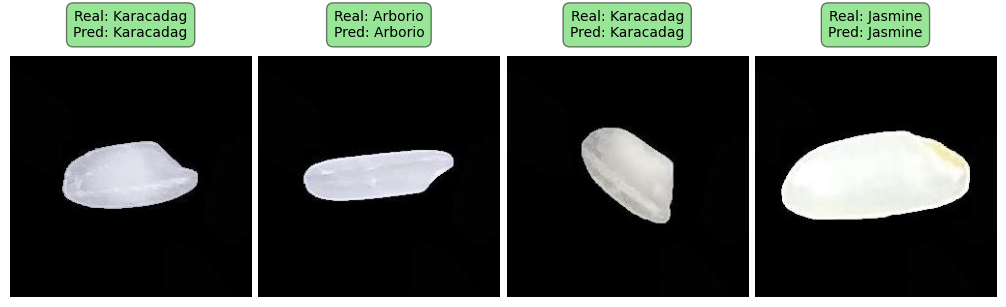

In [29]:
plt.figure(figsize=(10, 3))

for i in range(4):
    plt.subplot(1, 4, i+1)
    
    img = images[i].cpu()
    if img.ndim == 3 and img.shape[0] in [1, 3]:
        img = img.permute(1, 2, 0)
    plt.imshow(img.numpy())
    plt.axis('off')
    
    real_label = class_names[real_labels[i].item()]
    pred_label = class_names[pred_labels[i].item()]
        
    plt.title(
        f"Real: {real_label}\nPred: {pred_label}",
        fontsize=10,
        color='black',
        pad=10,
        y = 1.02,
        bbox=dict(
            boxstyle="round,pad=0.5", 
            facecolor='limegreen' if real_label == pred_label else 'salmon', 
            alpha=0.5
        )
    )

plt.tight_layout(pad=0.5)
plt.show()